In [1]:
# 0. Imports
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import tensorflow as tf
import joblib

# 1. Load Data
file_path = "/Users/jinsyl/ML Class/drug_disintegration_ml/data/raw/final_data_all_excipients.csv"
df = pd.read_csv(file_path)
X = df.drop(columns=['DISINTEGRATION_TIME'])
y = df['DISINTEGRATION_TIME']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Preprocessing: Scale features
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

# 3. Define Neural Network builder
def make_nn(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. Define Models
models = {
    'RF': RandomForestRegressor(n_estimators=200, random_state=42),
    'LGBM': lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
    'SVR': GridSearchCV(SVR(), {'C': [1, 10], 'gamma': ['scale', 'auto']}, cv=3),
    'KNN': GridSearchCV(KNeighborsRegressor(), {'n_neighbors': [5, 10]}, cv=3),
    'ANN': make_nn(Xtr_s.shape[1])
}

# 5. Train & Evaluate
results = {}
for name, model in models.items():
    print(f"🧪 Training {name}...")
    if name == 'ANN':
        model.fit(Xtr_s, y_train, epochs=50, batch_size=32, verbose=0)
        preds = model.predict(Xte_s).flatten()
    else:
        model.fit(Xtr_s, y_train)
        preds = model.predict(Xte_s)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"✅ {name}: RMSE={rmse:.2f}, R²={r2:.3f}")

# 6. Save Best Model
best_name = max(results, key=lambda k: results[k]['R2'])
print("\n🏆 Best model:", best_name, results[best_name])

# Save model (except ANN which is Keras and requires special saving)
os.makedirs("models", exist_ok=True)
if best_name != 'ANN':
    joblib.dump(models[best_name], f"models/best_model_{best_name}.joblib")
    print(f"📦 Saved best model to models/best_model_{best_name}.joblib")
else:
    models['ANN'].save("models/best_model_ANN.h5")
    print("📦 Saved best ANN model to models/best_model_ANN.h5")


2025-06-28 21:06:10.174944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-28 21:06:17.598778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


🧪 Training RF...
✅ RF: RMSE=24.64, R²=0.666
🧪 Training LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4106
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 51
[LightGBM] [Info] Start training from score 48.648380
✅ LGBM: RMSE=23.53, R²=0.696
🧪 Training SVR...
✅ SVR: RMSE=35.92, R²=0.291
🧪 Training KNN...
✅ KNN: RMSE=31.38, R²=0.459
🧪 Training ANN...
13/13 [==============================] - 0s 1ms/step
✅ ANN: RMSE=29.79, R²=0.512

🏆 Best model: LGBM {'RMSE': 23.52583215871914, 'R2': 0.6959543003126802}
📦 Saved best model to models/best_model_LGBM.joblib


In [3]:
import warnings
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# 📵 Suppress LightGBM warning output
warnings.filterwarnings("ignore", category=UserWarning)

# 🧪 Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15],
    'num_leaves': [31, 60, 90],
    'min_child_samples': [10, 20],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
}

# 🏗️ Set up grid search
lgbm_base = LGBMRegressor(n_estimators=300, random_state=42, verbosity=-1)
grid = GridSearchCV(
    estimator=lgbm_base,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

# 🚀 Fit search
grid.fit(Xtr_s, y_train)

# 📈 Evaluate on test set
best_lgbm = grid.best_estimator_
preds = best_lgbm.predict(Xte_s)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("🔍 Best Parameters from Grid Search:")
print(grid.best_params_)
print(f"\n🏆 Tuned LGBM (GridSearch) – RMSE: {rmse:.2f}, R²: {r2:.3f}")

# 💾 Save the improved model
joblib.dump(best_lgbm, "models/best_model_LGBM_GridSearch.joblib")


🔍 Best Parameters from Grid Search:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 10, 'num_leaves': 31, 'subsample': 0.7}

🏆 Tuned LGBM (GridSearch) – RMSE: 22.82, R²: 0.714


['models/best_model_LGBM_GridSearch.joblib']

In [3]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import warnings
import joblib

# Suppress LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 🧪 Mini test grid (only 4 combinations)
test_grid = {
    'learning_rate': [0.03, 0.05],
    'max_depth': [8, 10],
    'n_estimators': [300]
}

lgbm_quick = LGBMRegressor(random_state=42, verbosity=-1)

print("🚦 Starting quick GridSearch test...")
quick_search = GridSearchCV(
    estimator=lgbm_quick,
    param_grid=test_grid,
    cv=3,
    scoring='r2',
    n_jobs=2,     # use fewer cores for stability
    verbose=1     # shows progress
)

quick_search.fit(Xtr_s, y_train)

# ✅ Evaluate
best_lgbm_quick = quick_search.best_estimator_
y_pred_quick = best_lgbm_quick.predict(Xte_s)
rmse_quick = np.sqrt(mean_squared_error(y_test, y_pred_quick))
r2_quick = r2_score(y_test, y_pred_quick)

print("\n🎯 Best Parameters (Quick GridSearch):")
print(quick_search.best_params_)
print(f"\n🚀 Result – RMSE: {rmse_quick:.2f}, R²: {r2_quick:.3f}")

# 💾 Save model
joblib.dump(best_lgbm_quick, "models/best_model_LGBM_QuickTest.joblib")


🚦 Starting quick GridSearch test...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

🎯 Best Parameters (Quick GridSearch):
{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300}

🚀 Result – RMSE: 23.18, R²: 0.705


['models/best_model_LGBM_QuickTest.joblib']

In [4]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import warnings
import joblib

# Suppress LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ⚡ Optimized grid for M1 (reduced but meaningful)
refined_grid = {
    'learning_rate': [0.03, 0.05],
    'max_depth': [8, 10],
    'num_leaves': [50, 60],
    'min_child_samples': [10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'n_estimators': [300]
}

# Base model
lgbm_refined = LGBMRegressor(random_state=42, verbosity=-1)

# GridSearch with speed-safe settings
grid_search = GridSearchCV(
    estimator=lgbm_refined,
    param_grid=refined_grid,
    cv=2,              # faster CV
    scoring='r2',
    n_jobs=2,          # limits CPU load
    verbose=1          # show progress
)

print("🚀 Running optimized GridSearch on M1...")
grid_search.fit(Xtr_s, y_train)

# Evaluate best model
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(Xte_s)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n🎯 Best Parameters:")
print(grid_search.best_params_)
print(f"\n🏅 Tuned LGBM (Optimized) – RMSE: {rmse:.2f}, R²: {r2:.3f}")

# Save model
joblib.dump(best_lgbm, "models/best_model_LGBM_OptimizedM1.joblib")


🚀 Running optimized GridSearch on M1...
Fitting 2 folds for each of 256 candidates, totalling 512 fits

🎯 Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}

🏅 Tuned LGBM (Optimized) – RMSE: 21.48, R²: 0.747


['models/best_model_LGBM_OptimizedM1.joblib']

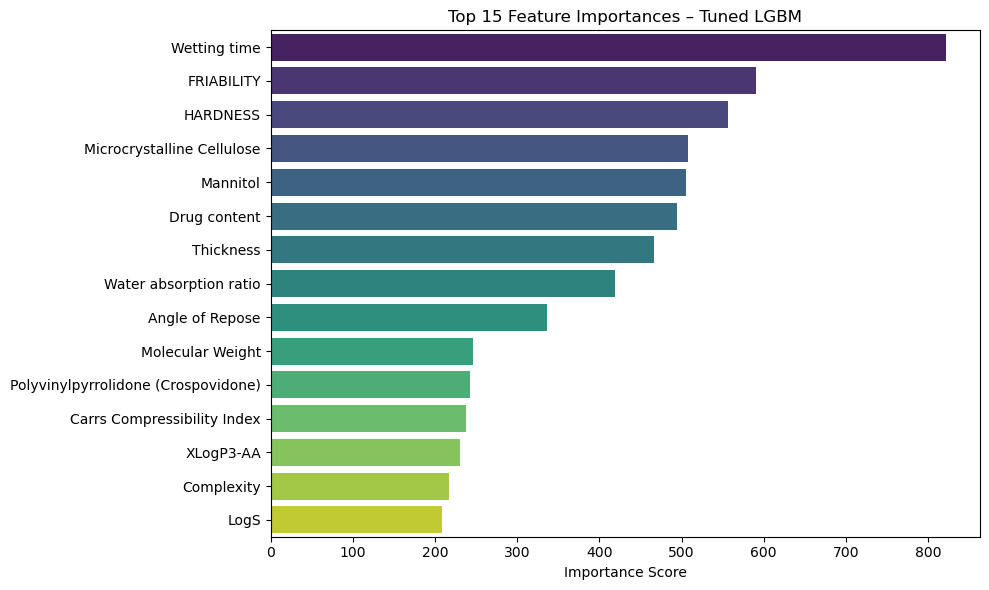

In [5]:


## 📊 Feature Importance Plot


import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(best_lgbm.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title("Top 15 Feature Importances – Tuned LGBM")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("models/feature_importance_lgbm.png")
plt.show()


In [6]:
df_preds = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})
df_preds.to_csv("models/lgbm_predictions.csv", index=False)
print("📄 Predictions saved to models/lgbm_predictions.csv")


📄 Predictions saved to models/lgbm_predictions.csv
